In [371]:
library(Quandl)
library(quantmod)
library(timeSeries)
library(corrplot)
library(ggplot2)
library(urca)
library(PerformanceAnalytics)
library(tseries)

In [3]:
Quandl.api_key('jXs6umTNNaQMp2G2sYm8')

In [111]:
pairs = c(
    "ETHBTC",
    "LTCBTC",
    "XRPBTC",
    "XMRBTC",
    "ZECBTC",
    "DSHBTC"
)
startDate = "2018-01-01"
endDate = "2018-12-01"

In [112]:
pairsDataList = list()
pairsDataListXts = list()

for(i in 1:length(pairs)){
    pair = pairs[i]
    bifinexPair = paste("BITFINEX/", pair, sep = "")
    pairData = Quandl(bifinexPair, start_date=startDate, end_date=endDate)
    assign(pair, pairData)
    pairDataXts = as.xts(pairData, order.by = pairData$Date, x=pairData$Last)
    pairsDataList[[i]] = pairData
    pairsDataListXts[[i]] = pairDataXts
}

In [113]:
matrix = merge(dailyReturn(pairsDataListXts[[1]]), dailyReturn(pairsDataListXts[[2]]), join="left")
for(i in 1:(length(pairs)-2)){
    matrix = merge(matrix, dailyReturn(pairsDataListXts[[(i+2)]]), join="left")
}
names(matrix) = pairs
matrix = na.approx(matrix)

In [114]:
cor(matrix)

,ETHBTC,LTCBTC,XRPBTC,XMRBTC,ZECBTC,DSHBTC
ETHBTC,1.0000000,0.4775187,0.4286515,0.3668552,0.4357721,0.4730251
LTCBTC,0.4775187,1.0000000,0.3710888,0.3842757,0.3307157,0.4441263
XRPBTC,0.4286515,0.3710888,1.0000000,0.2840632,0.2919728,0.3650813
XMRBTC,0.3668552,0.3842757,0.2840632,1.0000000,0.4015406,0.4623457
ZECBTC,0.4357721,0.3307157,0.2919728,0.4015406,1.0000000,0.4661462
DSHBTC,0.4730251,0.4441263,0.3650813,0.4623457,0.4661462,1.0000000


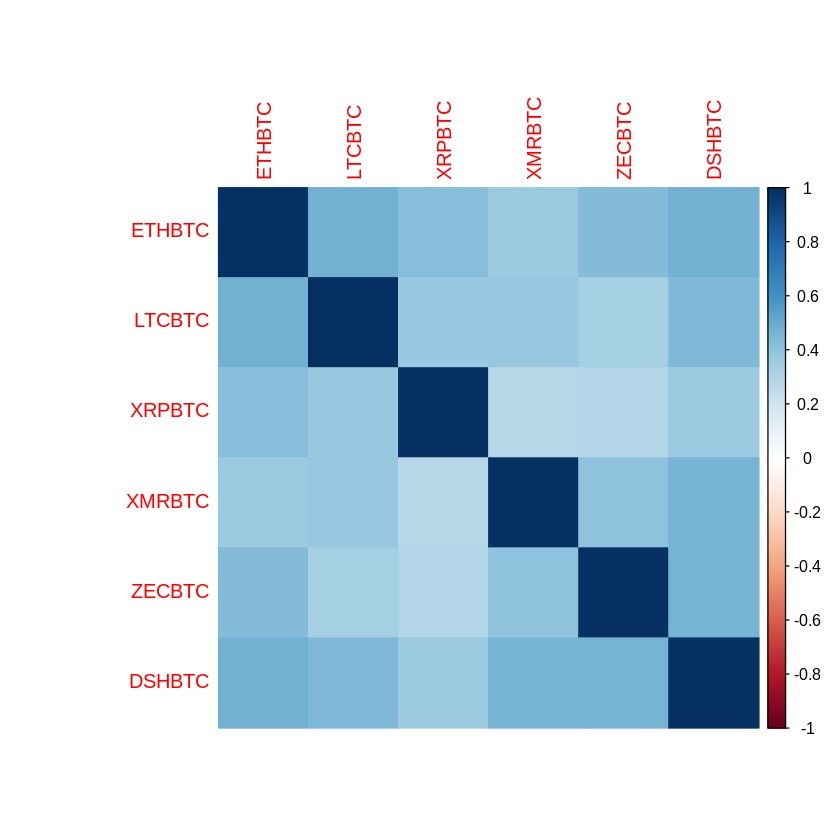

In [115]:
corrplot(cor(matrix), method="color")

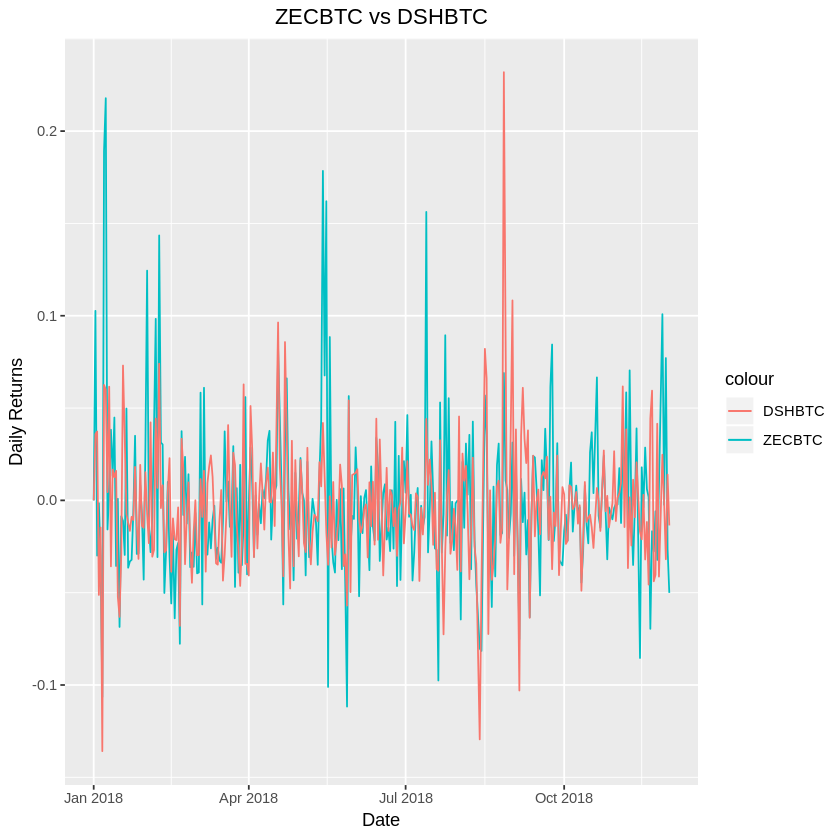

In [116]:
ggplot(matrix, aes(Index)) + 
    geom_line(aes(y = ZECBTC, col = "ZECBTC")) +
    geom_line(aes(y = DSHBTC, col = "DSHBTC")) +
    ggtitle("ZECBTC vs DSHBTC") +
    labs(x = "Date", y = "Daily Returns") +
    theme(plot.title = element_text(hjust = 0.5))

In [117]:
ZECBTCXTS = pairsDataListXts[[5]]
DSHBTCXTS = pairsDataListXts[[6]]
PAIRXTS = merge(ZECBTCXTS, DSHBTCXTS, join = "left")
names(PAIRXTS) = c("ZECBTC", "DSHBTC")

In [173]:
jotest=ca.jo(PAIRXTS, type="trace", K=2, ecdet="none", spec="longrun")
summary(jotest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.040592920 0.009793911

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  3.20  6.50  8.18 11.65
r = 0  | 16.67 15.66 17.95 23.52

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                          pairsDataListXts..i1...l2 pairsDataListXts..i2...l2
pairsDataListXts..i1...l2                  1.000000                  1.000000
pairsDataListXts..i2...l2                 -1.706048                  4.449369

Weights W:
(This is the loading matrix)

                         pairsDataListXts..i1...l2 pairsDataListXts..i2...l2
pairsDataListXts..i1...d              -0.005037767              -0.002719477
pairsDataListXts..i2...d               0.037322034              -0.001471445


In [172]:
# Print all pairs that has r = 0 above the critical value of 17.95
R0_CRITICAL = 17.95
for(i1 in 1:length(pairsDataListXts)){
    for(i2 in 1:length(pairsDataListXts)){
        if(i1 != i2){
            PAIRXTS = merge(pairsDataListXts[[i1]], pairsDataListXts[[i2]], join = "left")
            jotest=ca.jo(PAIRXTS, type="trace", K=2, ecdet="none", spec="longrun")
            if(jotest@teststat[2] >= R0_CRITICAL){
                print(paste(pairs[i1], pairs[i2]))
                print(jotest@teststat)
            }
        }
    }
}

[1] "ETHBTC XRPBTC"
[1]  2.615824 32.276714
[1] "ETHBTC DSHBTC"
[1]  1.711873 25.922373
[1] "XRPBTC ETHBTC"
[1]  2.615824 32.276714
[1] "XRPBTC ZECBTC"
[1]  4.433185 19.632115
[1] "ZECBTC XRPBTC"
[1]  4.433185 19.632115
[1] "DSHBTC ETHBTC"
[1]  1.711873 25.922373


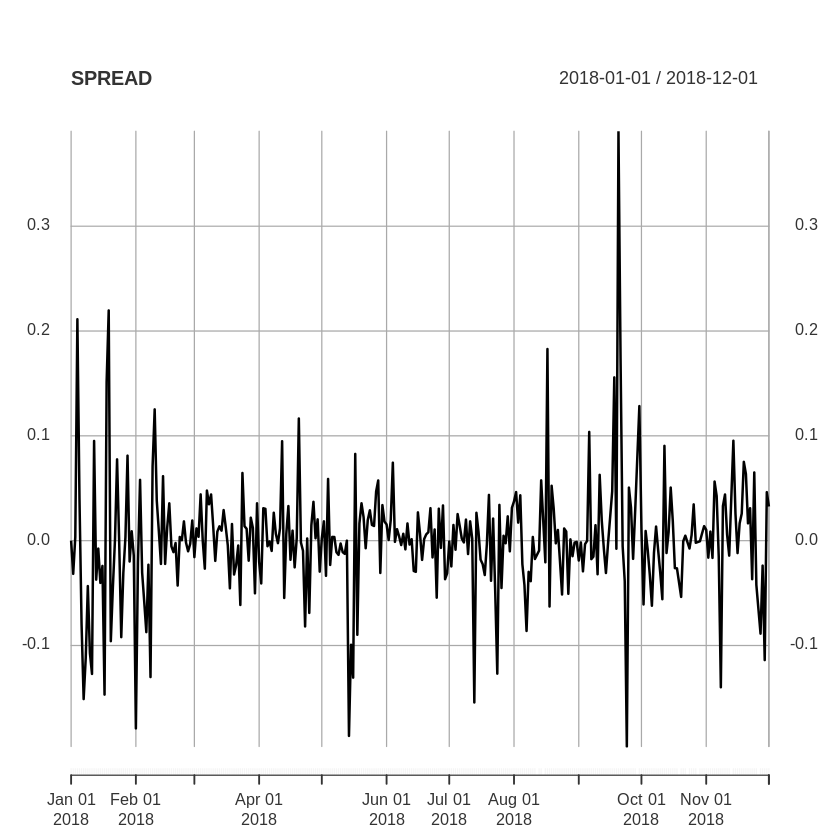

In [181]:
# Trying for XRPBTC(3) / ZECBTC(5)
XRPXTS_DR = dailyReturn(pairsDataListXts[[3]])
ZECBTS_DR = dailyReturn(pairsDataListXts[[5]])
SPREAD = XRPXTS_DR - ZECBTS_DR
plot(SPREAD)

In [372]:
adf.test(SPREAD)

Warning message in adf.test(SPREAD):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  SPREAD
Dickey-Fuller = -7.0876, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


In [335]:
# Function to calculate spead based on z-score
Z_SPREAD = function(x){
    return (x * sd(SPREAD) + mean(SPREAD))
}

In [367]:
# Enter when current return spread is 3 standard deviation away
# and exit when it's 1 standard deviation away
ENTER_RET = Z_SPREAD(3)
EXIT_RET = Z_SPREAD(1)

# 0 = neutral, 1 = long, -1 = short
signal = list()
signal[1] = 0
for(i in 2:nrow(SPREAD)){
    prevPosition = signal[i-1]
    ret = SPREAD[[i]]
    
    if(ret <= (-ENTER_RET)){
        # Enter long if return <= -ENTER_RET
        signal[i] = 1
    }else if(ret >= ENTER_RET){
        # Enter short if return >= ENTER_RET
        signal[i] = -1
    }else if(prevPosition == 1 && ret >= EXIT_RET){
        # Exit long if return >= EXIT_RET
        signal[i] = 0
    }else if(prevPosition == -1 && ret <= (-EXIT_RET)){
        # Exit short if return <= EXIT_RET
        signal[i] = 0
    }else{
        signal[i] = prevPosition
    }
}

RES = merge(SPREAD, signal)
# plot(RES)

# trade_return = SPREAD$daily.returns * lag(signal)
#     SPREAD$daily.returns
RES$tradeReturn = RES$daily.returns * lag(RES$signal)
head(RES)

           daily.returns signal tradeReturn
2018-01-01   0.000000000      0          NA
2018-01-02  -0.031663573      0  0.00000000
2018-01-03   0.003453594      0  0.00000000
2018-01-04   0.211254927     -1  0.00000000
2018-01-05   0.040585192     -1 -0.04058519
2018-01-06  -0.079457605      0  0.07945761

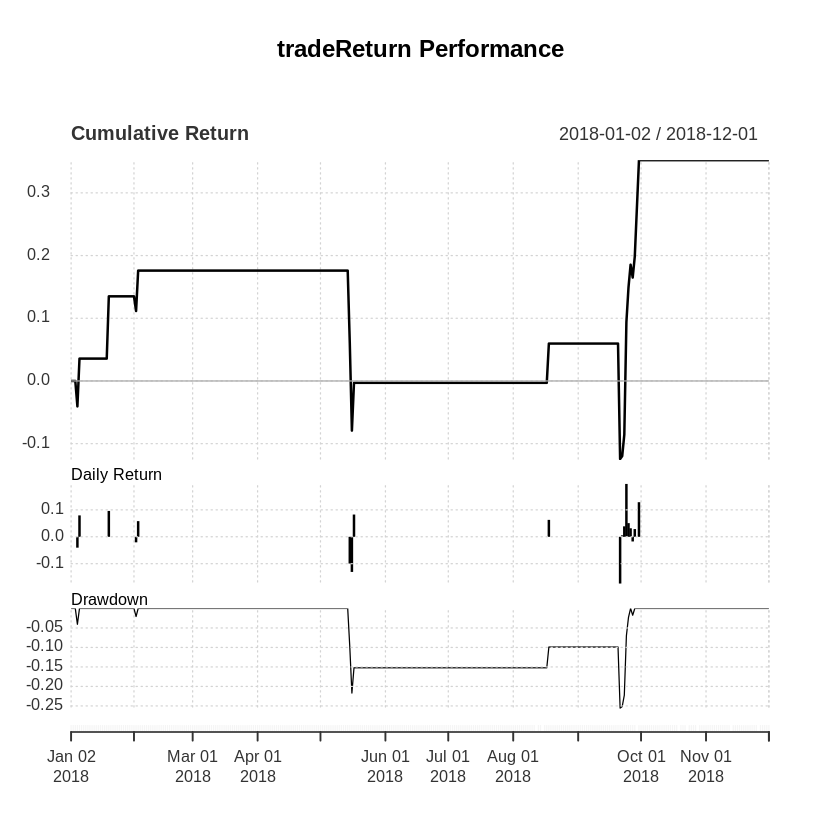

In [368]:
charts.PerformanceSummary(na.approx(RES$tradeReturn))

In [370]:
Return.cumulative(RES$tradeReturn)
Return.annualized(RES$tradeReturn)
maxDrawdown(RES$tradeReturn)
SharpeRatio(RES$tradeReturn, Rf = 0, p=0.95, FUN = "StdDev")
SharpeRatio.annualized(RES$tradeReturn, Rf = 0)

,tradeReturn
Cumulative Return,0.352222


,tradeReturn
Annualized Return,0.2627021


[1] 0.2555311

,tradeReturn
"StdDev Sharpe (Rf=0%, p=95%):",0.05379146


,tradeReturn
Annualized Sharpe Ratio (Rf=0%),0.7710583


## References
https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015
https://analyticsprofile.com/algo-trading/pair-trading-part-1-code-distance-based-pair-trading-strategy-in-r/